## Build canonical fashion-MNIST model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.1 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from skimage.transform import resize
from tensorflow.keras import mixed_precision

import glob

import cv2
from skimage.color import rgb2gray

from matplotlib.image import imread

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
# Enable mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')



In [ ]:
bag  = pd.read_json(r'/content/drive/MyDrive/Colab_Notebooks/group_project/V2_raw_data/bag_V2.json')
belt = pd.read_json(r'/content/drive/MyDrive/Colab_Notebooks/group_project/V2_raw_data/belt_V2.json')
boot = pd.read_json(r"/content/drive/MyDrive/Colab_Notebooks/group_project/V2_raw_data/boot_V2.json")
coat = pd.read_json(r"/content/drive/MyDrive/Colab_Notebooks/group_project/V2_raw_data/coat_V2.json")
dress = pd.read_json(r"/content/drive/MyDrive/Colab_Notebooks/group_project/V2_raw_data/dress_V2.json")
hat = pd.read_json(r"/content/drive/MyDrive/Colab_Notebooks/group_project/V2_raw_data/hat_V2.json")
polo = pd.read_json(r"/content/drive/MyDrive/Colab_Notebooks/group_project/V2_raw_data/polo_V2.json")
pullover = pd.read_json(r"/content/drive/MyDrive/Colab_Notebooks/group_project/V2_raw_data/pullover_V2.json")
sandal = pd.read_json(r"/content/drive/MyDrive/Colab_Notebooks/group_project/V2_raw_data/sandal_V2.json")
shorts = pd.read_json(r"/content/drive/MyDrive/Colab_Notebooks/group_project/V2_raw_data/shorts_V2.json")
sneaker = pd.read_json(r"/content/drive/MyDrive/Colab_Notebooks/group_project/V2_raw_data/sneaker_V2.json")
socks = pd.read_json(r"/content/drive/MyDrive/Colab_Notebooks/group_project/V2_raw_data/socks_V2.json")
sunglasses = pd.read_json(r"/content/drive/MyDrive/Colab_Notebooks/group_project/V2_raw_data/sunglasses_V2.json")
trouser = pd.read_json(r"/content/drive/MyDrive/Colab_Notebooks/group_project/V2_raw_data/trouser_V2.json")
tshirt = pd.read_json(r"/content/drive/MyDrive/Colab_Notebooks/group_project/V2_raw_data/tshirt_V2.json")
underwear = pd.read_json(r"/content/drive/MyDrive/Colab_Notebooks/group_project/V2_raw_data/underwear_V2.json")
# Concatenate all the data
data = pd.concat([bag, belt, boot, coat, dress, hat, polo, pullover, sandal, shorts, sneaker, socks, sunglasses, trouser, tshirt, underwear], axis=0)


In [ ]:
data.head()

,price,title,image,store,searchQuery
0,9.66,2023 Fashion Women Ball Bag Soft PU Leather Ro...,https://ae01.alicdn.com/kf/S95890d8e07a24b1198...,Angel LOVE Bag Store,bag_1
1,0.65,2023 New Chest Bag New Men Simple Nylon Fashio...,https://ae01.alicdn.com/kf/S123aeb052e8b43c289...,Beauty Bag Store,bag_2
2,2.88,Women's bag Brand Female Shoulder bag Handbag ...,https://ae01.alicdn.com/kf/S6caa5c47c306455994...,YSHKY Vip Bag Store,bag_3
3,0.99,New Style Simple Corduroy Small Square Handbag...,https://ae01.alicdn.com/kf/Sb7ce1b2999db4e1d91...,Shop5370096 Store,bag_4
4,54.56,designer luxury bag women bag,https://ae01.alicdn.com/kf/S0cf9fc9f995d4cb383...,DABEAU Store,bag_5


In [ ]:
# drop unimportant columns
data.drop(columns=["image", "store","searchQuery"],inplace=True)

Preprocessing the data.

In [ ]:
data["price"]. isnull().sum()

0

In [ ]:
data["price"] = pd.to_numeric(data["price"], errors='coerce')
missing_values = data["price"].isnull().sum()
print("Number of missing values in 'price' column:", missing_values)
# Fill the missing values with mean
mean_price = data["price"].mean()
data["price"].fillna(mean_price, inplace=True)


Number of missing values in 'price' column: 2


In [ ]:
# apply the log root transformation
data["price"] = np.log1p(data["price"])

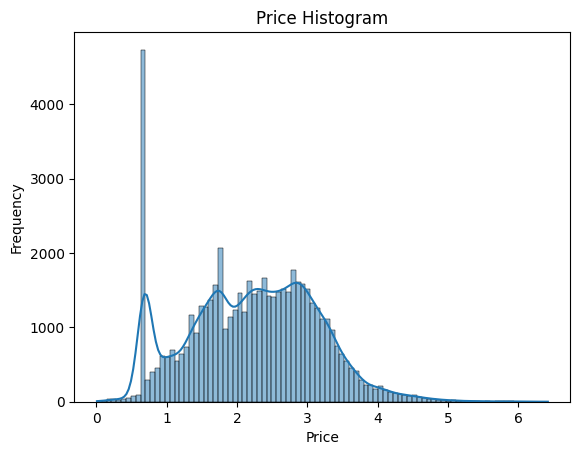

In [ ]:
#histogram of price
import seaborn as sns
import matplotlib.pyplot as plt


# Plot histogram
sns.histplot(data["price"], kde=True)

# Set labels and title
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.title("Price Histogram")

# Show the plot
plt.show()

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("stopwords")


# Function to clean and apply stemming or lemmatization to product description text
def clean_and_reduce_words(text, use_stemming=True):
    # Remove special characters, punctuation, and symbols
    cleaned_text = re.sub(r"[^a-zA-Z\s]", "", text)
    # Convert text to lowercase
    cleaned_text = cleaned_text.lower()
    # Tokenize text into individual words
    words = nltk.word_tokenize(cleaned_text)
    # Remove stop words
    stop_words = set(stopwords.words("english"))
    words = [word for word in words if word not in stop_words]
    # Apply stemming or lemmatization
    if use_stemming:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]
    else:
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]
    # Join words back into a cleaned sentence
    cleaned_text = " ".join(words)
    return cleaned_text

# Apply the clean_and_reduce_words function with stemming to the "title" column
data["title_stemmed"] = data["title"].apply(lambda x: clean_and_reduce_words(x, use_stemming=True))

# Apply the clean_and_reduce_words function with lemmatization to the "title" column
data["title_lemmatized"] = data["title"].apply(lambda x: clean_and_reduce_words(x, use_stemming=False))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data.head()

,price,title,title_stemmed,title_lemmatized
0,2.366498,2023 Fashion Women Ball Bag Soft PU Leather Ro...,fashion women ball bag soft pu leather round c...,fashion woman ball bag soft pu leather round c...
1,0.500775,2023 New Chest Bag New Men Simple Nylon Fashio...,new chest bag new men simpl nylon fashion wate...,new chest bag new men simple nylon fashion wat...
2,1.355835,Women's bag Brand Female Shoulder bag Handbag ...,women bag brand femal shoulder bag handbag fas...,woman bag brand female shoulder bag handbag fa...
3,0.688135,New Style Simple Corduroy Small Square Handbag...,new style simpl corduroy small squar handbag i...,new style simple corduroy small square handbag...
4,4.017464,designer luxury bag women bag,design luxuri bag women bag,designer luxury bag woman bag


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec

# Train the Word2Vec model on the preprocessed text
model = Word2Vec(sentences=data["title_lemmatized"], vector_size=100, window=5, min_count=1, workers=4)



In [ ]:
def get_word_embedding(words):
    embeddings = [model.wv[word] for word in words if word in model.wv]
    return embeddings

In [ ]:
# Convert each text in "title_lemmatized" to word embeddings
X = data["title_lemmatized"].apply(get_word_embedding)

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split


In [ ]:
# Convert word embeddings to numpy array
#X = np.array(data["title_lemmatized"].apply(get_word_embedding).tolist())
y = np.array(data["price"])

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming X is a pandas Series containing lists of word embeddings
# and fixed maximum length for the embeddings
max_length = 20

# Pad the word embeddings to a fixed length
X_padded = pad_sequences(X.tolist(), maxlen=max_length, dtype='float32', padding='post', truncating='post')

# Convert the padded embeddings to a 2D numpy array
X_2d = np.array(X_padded)

# Check the shape of the new 2D array
print("Shape of X_2d:", X_2d.shape)



Shape of X_2d: (56612, 20, 100)


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_2d, y, test_size=0.2, random_state=42)

In [ ]:
# Create the feedforward neural network model
import tensorflow as tf
from tensorflow.keras import layers

model = tf.keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(20, 100)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # Output layer with one neuron for regression
])


In [ ]:
# Compile the model with an appropriate loss function (e.g., mean squared error) and optimizer
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])


In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=8, validation_split=0.1)


Epoch 1/10
5095/5095 [==============================] - 358s 70ms/step - loss: 0.8709 - accuracy: 0.0000e+00 - val_loss: 0.8383 - val_accuracy: 0.0000e+00
Epoch 2/10
5095/5095 [==============================] - 335s 66ms/step - loss: 0.8589 - accuracy: 0.0000e+00 - val_loss: 0.8439 - val_accuracy: 0.0000e+00
Epoch 3/10
5095/5095 [==============================] - 319s 63ms/step - loss: 0.8553 - accuracy: 0.0000e+00 - val_loss: 0.8271 - val_accuracy: 0.0000e+00
Epoch 4/10
5095/5095 [==============================] - 327s 64ms/step - loss: 0.8531 - accuracy: 0.0000e+00 - val_loss: 0.8337 - val_accuracy: 0.0000e+00
Epoch 5/10
5095/5095 [==============================] - 321s 63ms/step - loss: 0.8528 - accuracy: 0.0000e+00 - val_loss: 0.8275 - val_accuracy: 0.0000e+00
Epoch 6/10
5095/5095 [==============================] - 325s 64ms/step - loss: 0.8523 - accuracy: 0.0000e+00 - val_loss: 0.8269 - val_accuracy: 0.0000e+00
Epoch 7/10
5095/5095 [==============================] - 328s 64ms/step

In [ ]:
# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)
print("Test loss:", loss)

354/354 [==============================] - 36s 101ms/step - loss: 0.8432 - accuracy: 0.0000e+00
Test loss: [0.8431906700134277, 0.0]


In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test)


354/354 [==============================] - 36s 100ms/step


In [ ]:
# Calculate Mean Squared Error (MSE)
mse = tf.keras.metrics.mean_squared_error(y_test, y_pred)

In [ ]:
# Calculate Root Mean Squared Error (RMSE)
rmse = tf.keras.metrics.mean_squared_error(y_test, y_pred)

In [ ]:
print("Mean Absolute Error (MAE):",np.mean(mse.numpy()))
print("Root Mean Squared Error (RMSE):",np.mean(rmse.numpy()))

Mean Absolute Error (MAE): 0.8433
Root Mean Squared Error (RMSE): 0.8433
